In [ ]:
라이브러리 임포트

In [24]:
import numpy as np
import matplotlib.pyplot as pylab
from matplotlib import cm

from skimage import img_as_float, data
from skimage.data import astronaut
from skimage.io import imread
from skimage.color import rgb2gray, label2rgb, gray2rgb, rgba2rgb

from skimage.filters import sobel, threshold_otsu
from skimage.draw import circle_perimeter
from skimage.feature import canny
from skimage.transform import (hough_line, hough_line_peaks, \
                               hough_circle, hough_circle_peaks)
from skimage.segmentation import (felzenszwalb, slic, quickshift, \
                                  watershed, mark_boundaries, find_boundaries)

In [25]:
#영상 보기 함수
def plot_image(image, title, cmap='gray'):
    pylab.imshow(image, cmap=cmap), pylab.title(title, size=20), pylab.axis('off')
    
def plot_ax_image(ax, image, title, cmap='gray', size = 20):
    ax.imshow(image, cmap=cmap)
    ax.set_title(title), ax.axis('off')

In [ ]:
하프 변환 - 직선과 원 검출

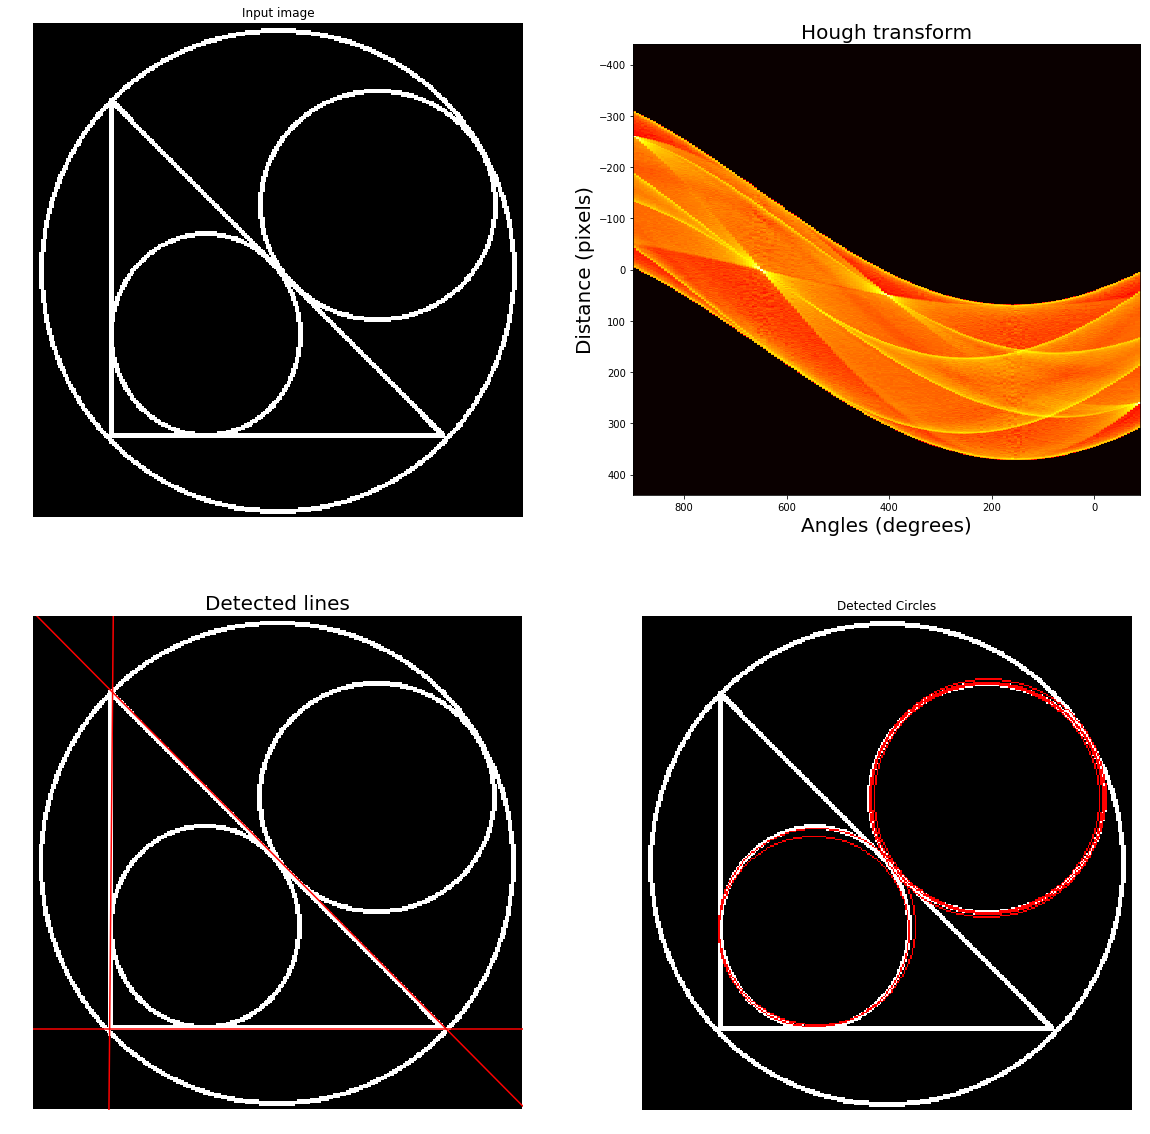

In [5]:
image = rgba2rgb(imread('../images/triangle_circle.png')) # 알파 채널 포함됨
gray = rgb2gray(image)
fig, axes = pylab.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()
plot_ax_image( axes[0], image, 'Input image')

h, theta, d = hough_line(gray) # 하프 변환 수행
extent = [10*np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]]
axes[1].imshow(np.log(1 + h), extent=extent, cmap=cm.hot, aspect=1/1.5)
axes[1].set_title('Hough transform', size=20)
axes[1].set_xlabel('Angles (degrees)', size=20)
axes[1].set_ylabel('Distance (pixels)', size=20)
axes[1].axis('image')

hough = hough_line_peaks(h, theta, d) # 하프 행렬에서 피크 값의 각도, 거리
axes[2].imshow(image, cmap='gray')
for _, angle, dist in zip(*hough):
    x0, y0 = 0 , image.shape[1]
    x1 = (dist - x0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - y0 * np.cos(angle)) / np.sin(angle)
    axes[2].plot((x0, y0), (x1, y1), '-r')
axes[2].set_xlim((0, image.shape[1])), axes[2].set_ylim((image.shape[0],0))
axes[2].set_axis_off(), axes[2].set_title('Detected lines', size=20)

# Circle 하프 변환
hough_radii = np.arange(50, 100, 2)
hough_res = hough_circle(gray, hough_radii)
# 누적이 많은 6개 원 선택
circle_param = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=6)

for _, c_x, c_y, radius in zip(*circle_param):
    cir_points = circle_perimeter(c_y, c_x, radius)
    image[cir_points] = (1, 0, 0)
plot_ax_image(axes[3], image, 'Detected Circles')
pylab.show()

In [ ]:
동전 객체 분할

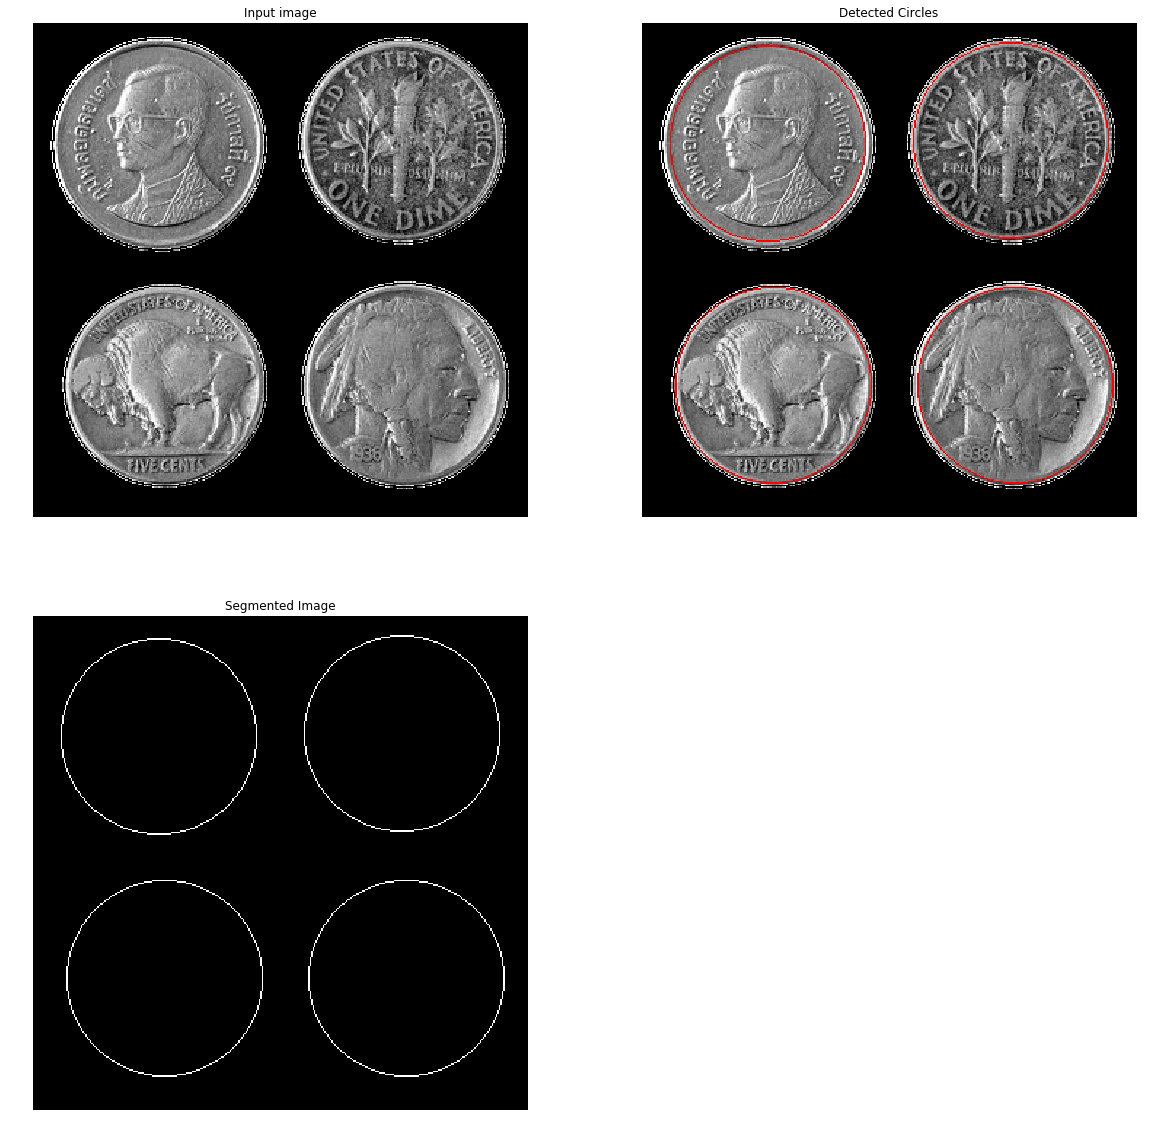

In [5]:
image = rgb2gray(imread('../images/coins.png'))
hough_radii = np.arange(65, 75, 1)
hough_res = hough_circle(image, hough_radii) # 원 하프 변환

# 하프 행렬 피크가 큰 4개 원 선택
circle_param = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=4)
detected_image = gray2rgb(image)
segmented_image = np.zeros_like(image)

for _, c_x, c_y, radius in zip(*circle_param):
    cir_points = circle_perimeter(c_y, c_x, radius)
    detected_image[cir_points] = (1, 0, 0)
    segmented_image[cir_points] = 1
    
_, axes = pylab.subplots(2, 2, figsize=(20, 20))
plot_ax_image(axes[0][0], image, 'Input image')
plot_ax_image(axes[0][1], detected_image, 'Detected Circles')
plot_ax_image(axes[1][0], segmented_image, 'Segmented Image')
pylab.axis('off')
pylab.show()

In [ ]:
오쓰의 분할 구현

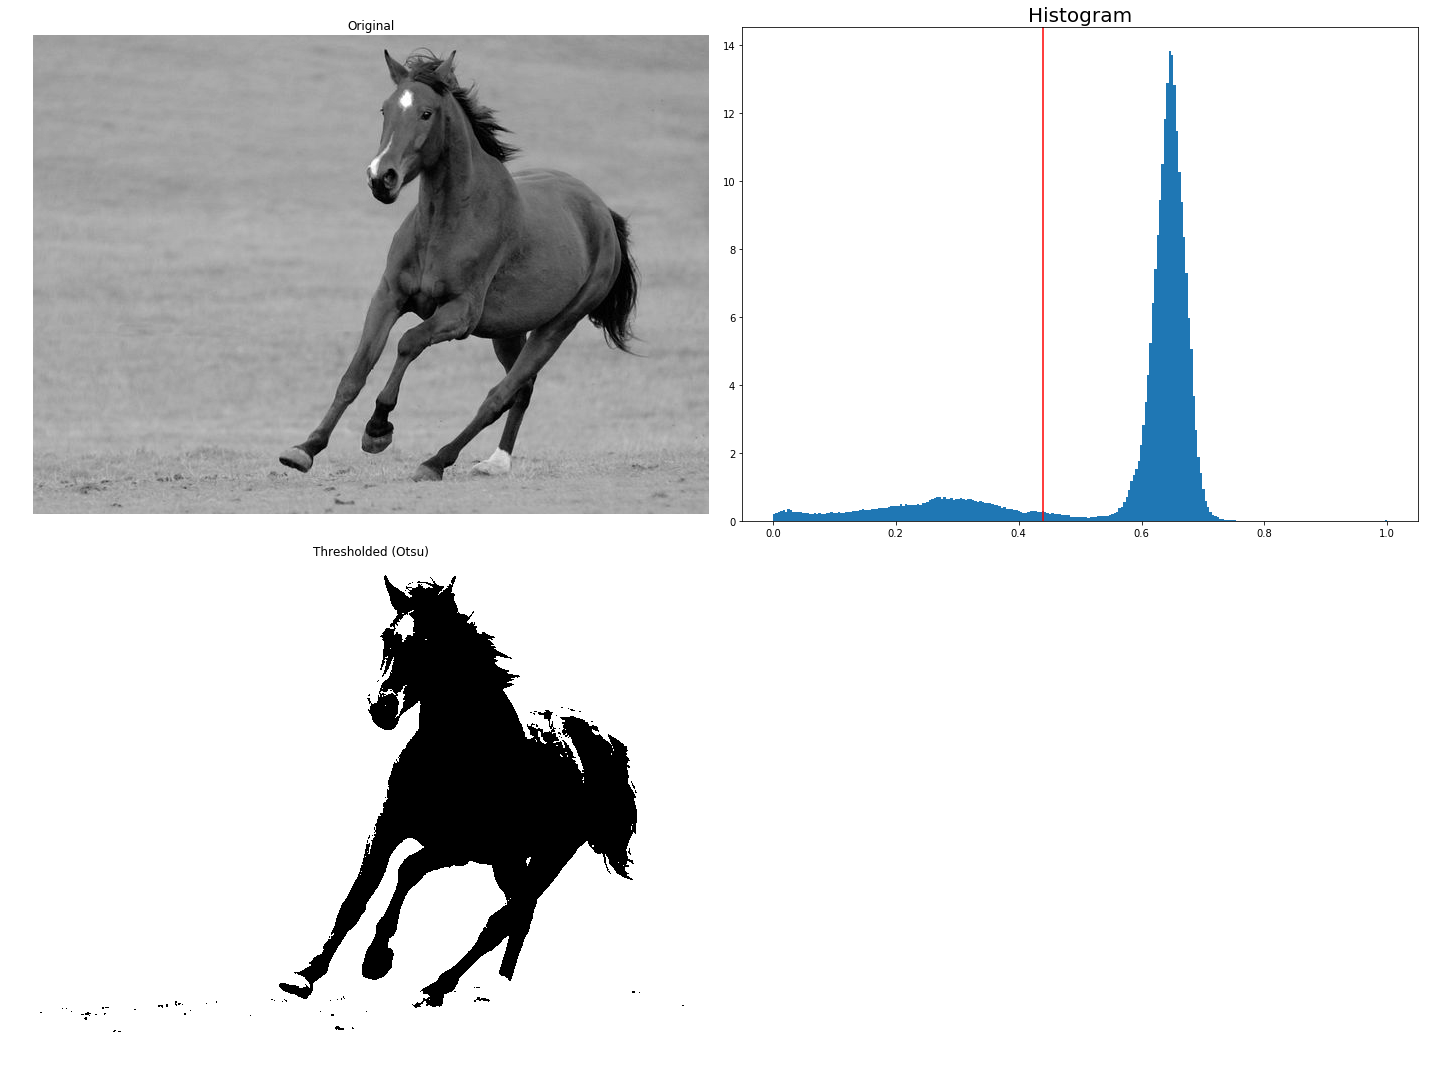

In [6]:
image = rgb2gray(imread('../images/horse.jpg'))
thresh = threshold_otsu(image)
binary = image > thresh

_, axes = pylab.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()
plot_ax_image(axes[0], image , 'Original')
axes[1].hist(image.ravel(), bins=256, density=True)
axes[1].set_title('Histogram', size=20), axes[1].axvline(thresh, color='r')
plot_ax_image(axes[2], binary , 'Thresholded (Otsu)')
axes[3].axis('off'), pylab.tight_layout()
pylab.show()

In [ ]:
에지 기반/영역 기반 분할 - 명암도 영상과 밝기 히스토그램

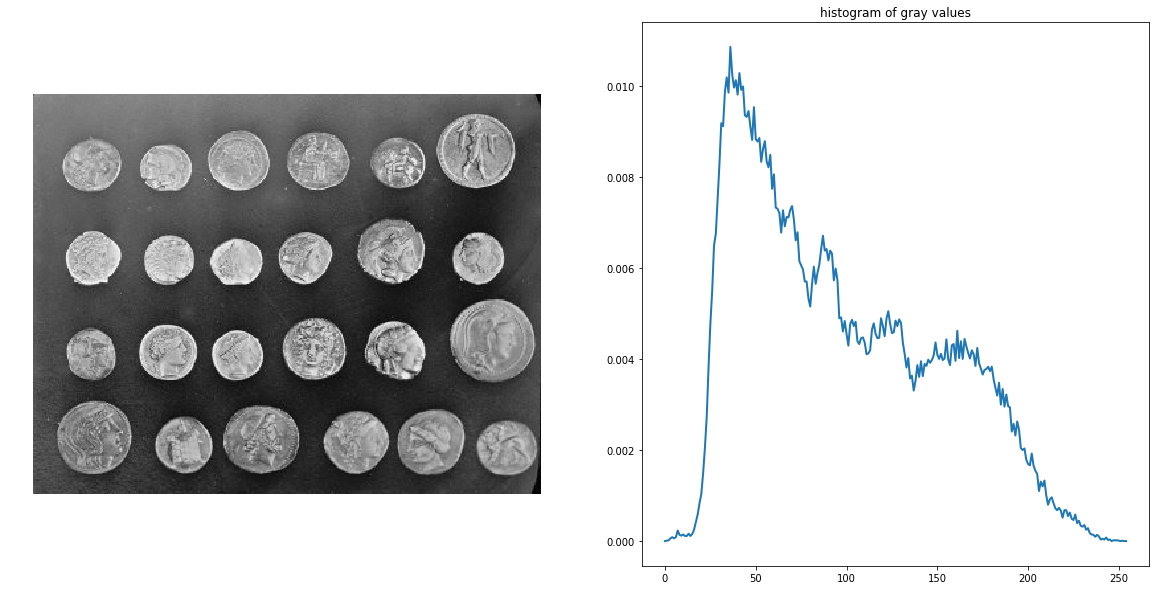

In [18]:
coins = data.coins()
hist = np.histogram(coins, bins=np.arange(0, 256), density=True)
fig, axes = pylab.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(coins, cmap='gray'), axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw=2),
axes[1].set_title('histogram of gray values')
pylab.show()

In [ ]:
에지 기반 분할

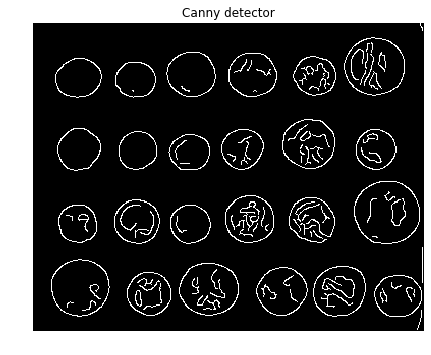

In [19]:
edges = canny(coins, sigma=2)
fig, axes = pylab.subplots(figsize=(7, 7))
plot_ax_image(axes, edges , 'Canny detector') # 영상 표시 함수 사용
pylab.show()

In [ ]:
윤곽선 채움 - scipy ndimage 모듈의 binary_fill_holes() 사용

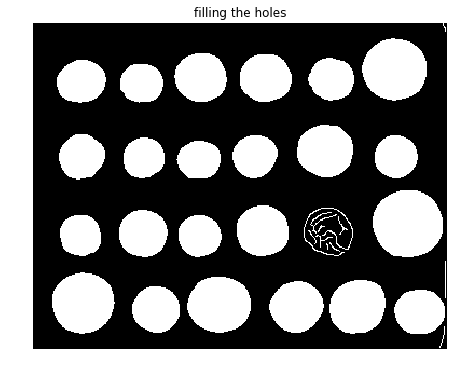

In [20]:
from scipy import ndimage as ndi

fill_coins = ndi.binary_fill_holes(edges)
_, axes = pylab.subplots(figsize=(10,6))
plot_ax_image(axes, fill_coins , 'filling the holes') # 영상 표시 함수 사용
pylab.show()

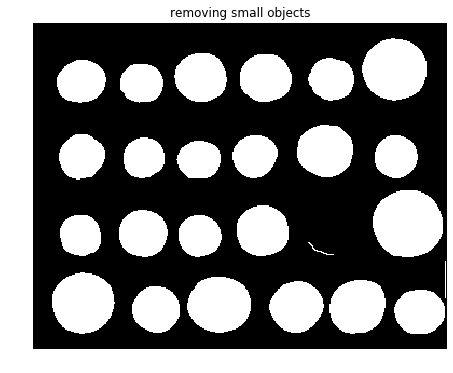

In [21]:
from skimage import morphology

coins_cleaned = morphology.remove_small_objects(fill_coins, 21)
_, axes = pylab.subplots(figsize=(10,6))
plot_ax_image(axes, coins_cleaned , 'removing small objects')
pylab.show()

In [ ]:
소벨 그레디언트를 사용하여 고도 지도

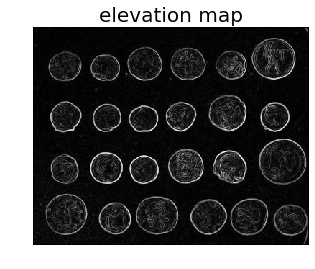

In [26]:
elevation_map = sobel(coins)
plot_image(elevation_map , 'elevation map')
pylab.show()

In [ ]:
히스토그램의 극단적인 부분에 기초한 배경과 동전의 마커 계산

2 0


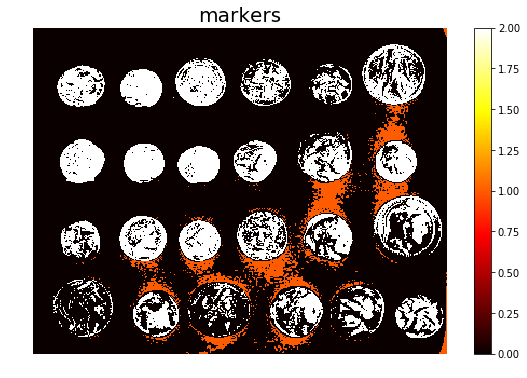

In [27]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2
print(np.max(markers), np.min(markers)) # 2 0

pylab.figure(figsize=(10,6))
plot_image(markers , 'markers', cmap='hot'), pylab.colorbar()
pylab.show()

In [ ]:
고도 지도의 영역 채움

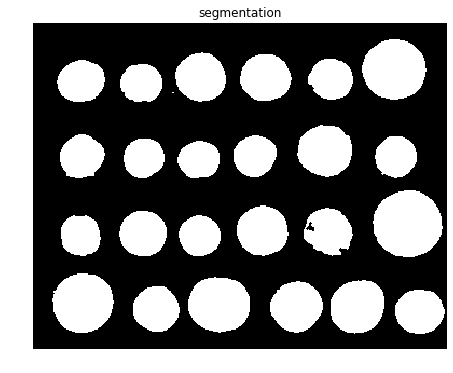

In [28]:
from skimage import morphology

segmentation = morphology.watershed(elevation_map, markers)
fig, axes = pylab.subplots(figsize=(10, 6))
plot_ax_image(axes, segmentation, 'segmentation')
pylab.show()

In [ ]:
동전 분류 및 레이블링

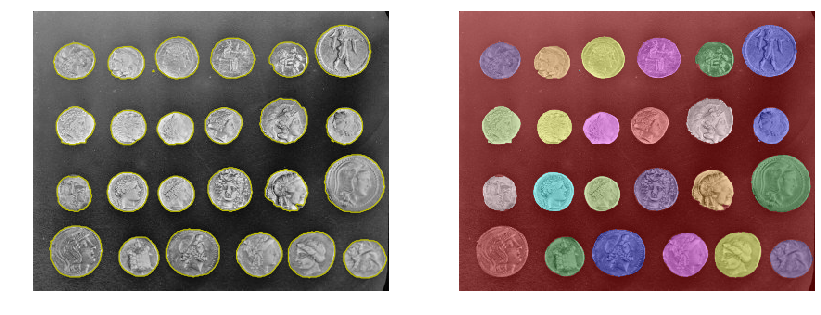

In [29]:
from scipy import ndimage as ndi

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=coins)

fig, axes = pylab.subplots(1, 2, figsize=(14, 6), sharey=True)
axes[0].imshow(coins, cmap=pylab.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

axes[0].axis('off'), axes[1].axis('off')
pylab.show()